In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!pip install ultralytics pandas numpy
import os
import json
import numpy as np
from ultralytics import YOLO

In [3]:
import sys
# ROOT_DIR 설정
ROOT_DIR = '/content/drive/MyDrive/DeepLearning'
IMG_W, IMG_H = 1280, 1280
DATA_YAML_PATH = os.path.join(ROOT_DIR, "data.yaml")

# 파이썬이 Drive의 ROOT_DIR에서 모듈을 찾을 수 있도록 경로 추가
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

print(f"✅ 환경 설정 및 경로 추가 완료: {ROOT_DIR}이 시스템 경로에 추가되었습니다.")

✅ 환경 설정 및 경로 추가 완료: /content/drive/MyDrive/DeepLearning이 시스템 경로에 추가되었습니다.


In [4]:
try:
    from scoring_system import get_scores
    from case_classifier import get_analysis_label, get_script
    from convert_json_to_txt import convert_json_to_txt  # JSON 변환 함수도 로드
    print("✅ 모든 모듈(함수) 로드 완료.")
except ImportError as e:
    print(f"❌ 모듈 로드 실패: {e}. 'DeepLearning' 폴더 안에 해당 파일들이 모두 있는지 확인하세요.")

변환 완료: temp_data.json -> ./temp_data.txt
✅ 모든 모듈(함수) 로드 완료.


In [5]:
import os
import json
import numpy as np

CLASS_NAMES = ["집전체", "문", "창문", "울타리", "길", "태양", "굴뚝", "지붕", "연기", "나무", "꽃", "잔디", "연못"]
LABEL_MAP = {name: i for i, name in enumerate(CLASS_NAMES)}

def convert_json_to_txt(root_dir, img_w=1280, img_h=1280):

    data_root = os.path.join(root_dir, "data")

    SPLIT_MAP = {
        'Training': 'Training/Labels',
        'Validation': 'Validation/Labels'
    }

    for split_name, sub_dir in SPLIT_MAP.items():
        process_dir = os.path.join(data_root, sub_dir)
        os.makedirs(process_dir, exist_ok=True)

        print(f"--- {split_name} 데이터 처리 시작: 경로: {process_dir} ---")

        if not os.path.exists(process_dir):
            print(f"❌ 오류: 경로가 존재하지 않아 처리할 수 없습니다: {process_dir}")
            continue

        for filename in os.listdir(process_dir):
            if not filename.endswith(".json"):
                continue

            base_name = os.path.splitext(filename)[0]
            txt_path = os.path.join(process_dir, base_name + ".txt")
            json_path = os.path.join(process_dir, filename)

            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
            except Exception as e:
                print(f"Error loading JSON {json_path}: {e}")
                continue

            lines = []
            if "annotations" in data and "bbox" in data["annotations"]:
                for obj in data["annotations"]["bbox"]:
                    label = obj.get("label")
                    if label not in LABEL_MAP:
                        continue

                    x, y, w, h = obj.get("x", 0), obj.get("y", 0), obj.get("w", 0), obj.get("h", 0)

                    # YOLO 포맷으로 정규화 (cx, cy, norm_w, norm_h)
                    cx = (x + w / 2) / img_w
                    cy = (y + h / 2) / img_h
                    norm_w = w / img_w
                    norm_h = h / img_h

                    class_id = LABEL_MAP[label]
                    lines.append(f"{class_id} {cx:.6f} {cy:.6f} {norm_w:.6f} {norm_h:.6f}")

                with open(txt_path, "w") as f:
                    f.write("\n".join(lines))

        txt_count = len([f for f in os.listdir(process_dir) if f.endswith('.txt')])
        print(f"✅ {split_name} 라벨 변환 완료. TXT 파일 {txt_count}개 저장.")

In [ ]:
print("--- 1단계: JSON 라벨 TXT 변환 시작 ---")

try:
    convert_json_to_txt(ROOT_DIR, IMG_W, IMG_H)
    print("✅ JSON to TXT 변환 프로세스 성공적으로 완료.")
except Exception as e:
    print(f"❌ JSON 변환 중 최종 오류 발생: {e}")

--- 1단계: JSON 라벨 TXT 변환 시작 ---
--- Training 데이터 처리 시작: 경로: /content/drive/MyDrive/DeepLearning/data/Training/Labels ---
✅ Training 라벨 변환 완료. TXT 파일 11200개 저장.
--- Validation 데이터 처리 시작: 경로: /content/drive/MyDrive/DeepLearning/data/Validation/Labels ---
✅ Validation 라벨 변환 완료. TXT 파일 1400개 저장.
✅ JSON to TXT 변환 프로세스 성공적으로 완료.


In [6]:
try:
    with open(DATA_YAML_PATH, 'r', encoding='utf-8') as f:
        data_yaml_content = f.read()
    print("\n--- 2단계: data.yaml 파일 내용 확인 ---")
    print(data_yaml_content)
    print("✅ data.yaml 경로 확인 완료.")
except FileNotFoundError:
    print(f"❌ data.yaml 파일을 찾을 수 없습니다: {DATA_YAML_PATH}")


--- 2단계: data.yaml 파일 내용 확인 ---
path: /content/drive/MyDrive/DeepLearning/data
train: images/train
val: images/val
nc: 13
names: ["집전체", "문", "창문", "울타리", "길", "태양", "굴뚝", "지붕", "연기", "나무", "꽃", "잔디", "연못"]
✅ data.yaml 경로 확인 완료.


In [7]:
import torch
torch.cuda.is_available()

False

In [8]:
print("\n--- 3단계: YOLOv8 모델 학습 시작 ---")

MODEL_SAVE_NAME = "yolov8s-final-real"

try:
    MODEL_PATH = os.path.join(ROOT_DIR, "detections", MODEL_SAVE_NAME, "weights", "best.pt")

    if os.path.exists(MODEL_PATH):
        print(f"⚠️ 이미 학습된 모델({MODEL_PATH})이 존재합니다. 학습을 건너뛰고 분석으로 진행합니다.")
    else:
        model_yolo = YOLO("yolov8s.pt")
        model_yolo.train(
            data=DATA_YAML_PATH,
            epochs=50,
            imgsz=640,
            batch=16,
            device=0,
            project=os.path.join(ROOT_DIR, "detections"),
            name=MODEL_SAVE_NAME,
            pretrained=True,
            patience=10,
            workers=0
        )
        print("✅ 모델 학습 완료.")
except Exception as e:
    print(f"❌ 모델 학습 중 오류 발생: {e}")


--- 3단계: YOLOv8 모델 학습 시작 ---
⚠️ 이미 학습된 모델(/content/drive/MyDrive/DeepLearning/detections/yolov8s-final-real/weights/best.pt)이 존재합니다. 학습을 건너뛰고 분석으로 진행합니다.


In [12]:
SCRIPTS_JSON_PATH = os.path.join(ROOT_DIR, "scrips.json")
SCRIPT_DATA = {}
try:
    with open(SCRIPTS_JSON_PATH, 'r', encoding='utf-8') as f:
        SCRIPT_DATA = json.load(f)
    print("✅ scripts.json 파일 로드 완료.")
except FileNotFoundError:
    print(f"❌ scripts.json 파일을 찾을 수 없습니다: {SCRIPTS_JSON_PATH}. 스크립트 출력이 제한됩니다.")
except json.JSONDecodeError:
    print("❌ scripts.json 파일에 JSON 문법 오류가 있습니다. 파일 내용을 확인하세요.")

✅ scripts.json 파일 로드 완료.


--- 4단계: 심리 분석 실행 ---

✅ 모델 로드 완료: best.pt
Results saved to /content/drive/MyDrive/DeepLearning/runs/analysis_results9
✅ 탐지 완료: 총 34개의 객체 발견.

--- 🖼️ 분석 이미지  ---


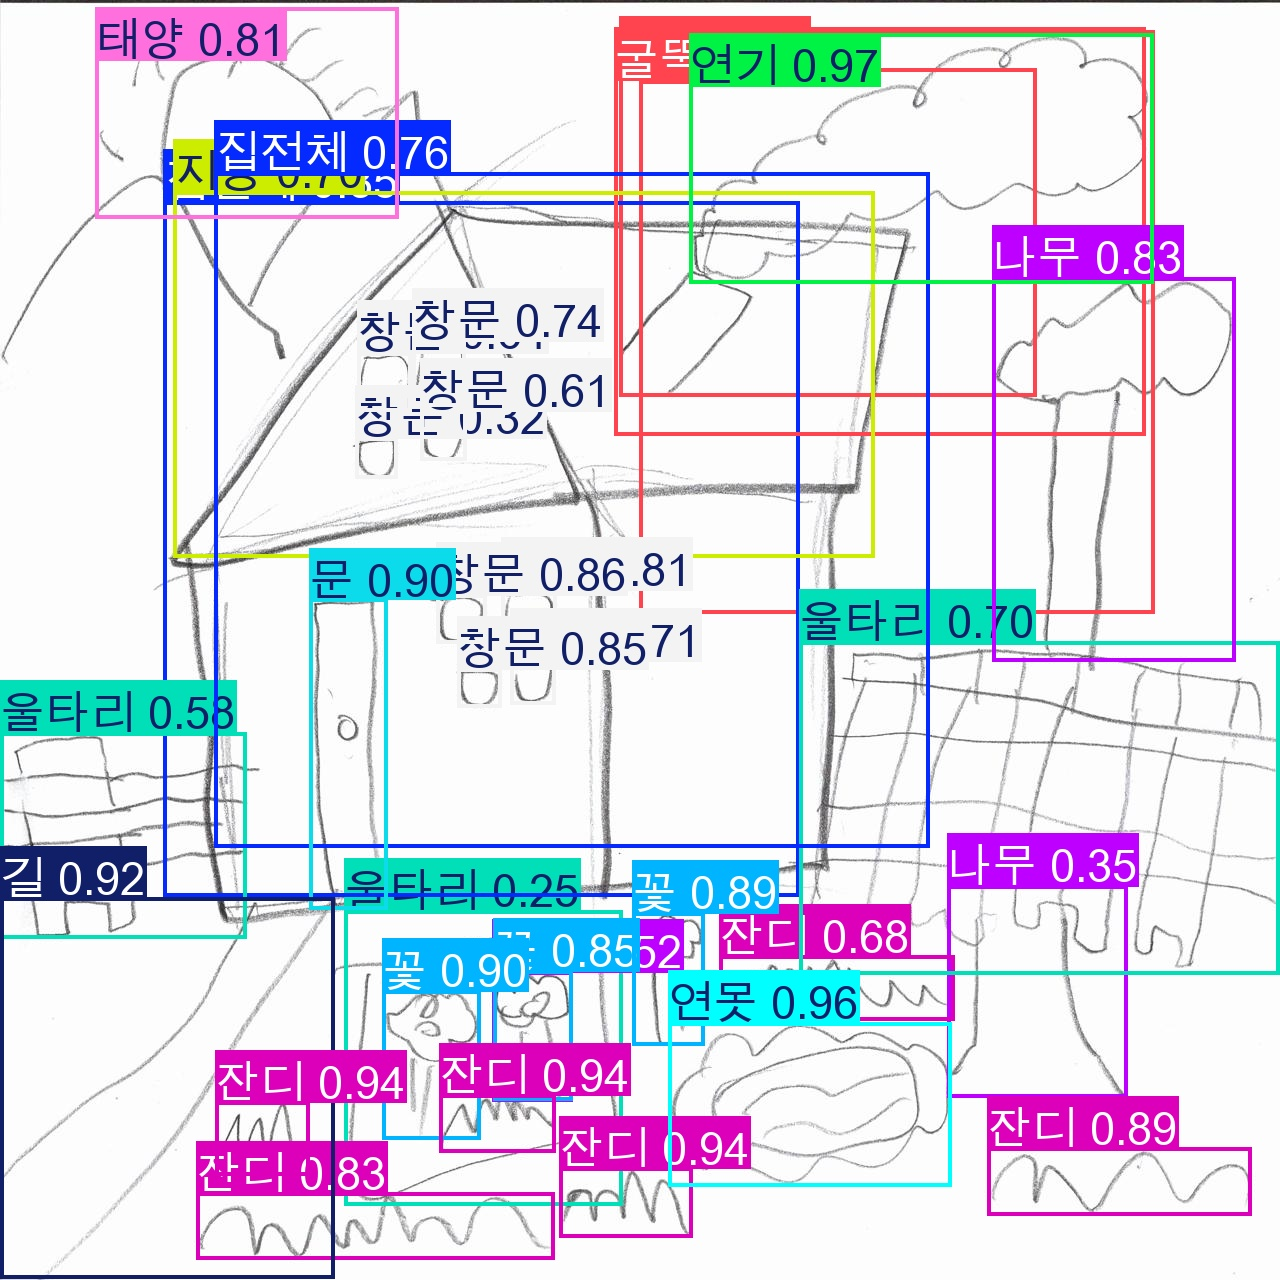


           ✨ 최종 심리 분석 결과 ✨
✔️ 최종 심리 케이스: 'WO'

[ 심리 지표 점수 ]
  - Openness  : 90.00 점
  - Vitality  : 85.30 점
  - Warmth    : 100.00 점
  - Stability : 71.90 점

[ 분석 스크립트 ]
당신은 따뜻함(W)과 개방성(O)이 매우 높은 이상적인 소통가입니다. Warmth 점수가 가장 높게 나왔듯이 타인의 감정에 깊이 공감하고 포용하는 능력이 뛰어납니다. 새로운 생각과 변화에 대해 항상 열려있는(O) 유연성을 겸비하여, 관계와 지적 성장에서 모두 뛰어난 능력을 발휘합니다.



In [14]:
def analyze_house_drawing(image_path):
    global SCRIPT_DATA, IMG_W, IMG_H, ROOT_DIR, MODEL_SAVE_NAME

    # 1. 모델 로드
    MODEL_PATH = os.path.join(ROOT_DIR, "detections", MODEL_SAVE_NAME, "weights", "best.pt")
    try:
        model = YOLO(MODEL_PATH)
        print(f"\n✅ 모델 로드 완료: {os.path.basename(MODEL_PATH)}")
    except Exception as e:
        print(f"❌ 모델 로드 실패: {e}. 학습이 완료되었는지 확인하세요.")
        return

    # --- 객체 탐지 (Detect) ---
    results = model(
        image_path,
        imgsz=IMG_W,
        conf=0.25,
        save=True,
        project=os.path.join(ROOT_DIR, "runs"),
        name="analysis_results",
        verbose=False
    )

    detections = []

    # 2. YOLO 좌표 추출 오류 수정 및 안정화
    for r in results:
      norm_coords = r.boxes.xywhn.tolist()
      pixel_coords = r.boxes.xyxy.tolist()
      for i, box in enumerate(r.boxes):
        cls = int(box.cls)

        # 정규화된 좌표와 픽셀 좌표 추출
        norm_c = norm_coords[i]
        pixel_c = pixel_coords[i]
        detections.append({
            'class_id': cls,
            'label': model.names[cls],
            'norm_x_center': norm_c[0],
            'norm_y_center': norm_c[1],

            'pixel_x1': pixel_c[0],
            'pixel_y1': pixel_c[1],
            'pixel_x2': pixel_c[2],
            'pixel_y2': pixel_c[3]
            })

    print(f"✅ 탐지 완료: 총 {len(detections)}개의 객체 발견.")

    # --- 3. 분석 이미지 시각화 출력 ---
    result_img_path = os.path.join(results[0].save_dir, os.path.basename(image_path))

    print("\n--- 🖼️ 분석 이미지  ---")
    if os.path.exists(result_img_path):
        from IPython.display import Image, display
        display(Image(filename=result_img_path, width=500))
    else:
        print(f"❌ 시각화 이미지 저장 경로를 찾을 수 없습니다: {result_img_path}")


    # --- 4. 심리 분석 및 결과 출력 (Scoring, Classification) ---
    psych_scores = get_scores(detections, IMG_W, IMG_H)
    final_label = get_analysis_label(psych_scores)
    analysis_script = get_script(final_label, SCRIPT_DATA)

    print("\n" + "="*40)
    print("           ✨ 최종 심리 분석 결과 ✨")
    print("="*40)
    print(f"✔️ 최종 심리 케이스: '{final_label}'")

    print("\n[ 심리 지표 점수 ]")
    for key, value in psych_scores.items():
        print(f"  - {key.capitalize():<10}: {value:.2f} 점")

    print("\n[ 분석 스크립트 ]")
    print(analysis_script)
    print("="*40 + "\n")

    return psych_scores, final_label, analysis_script

# --- 최종 실행 ---
TEST_IMAGE_PATH = os.path.join(ROOT_DIR, 'test_image.jpg')
print(f"--- 4단계: 심리 분석 실행 ---")

if not os.path.exists(TEST_IMAGE_PATH):
    print(f"⚠️ 테스트 이미지 파일({TEST_IMAGE_PATH})을 찾을 수 없습니다. 분석을 위해 파일을 해당 경로에 업로드하세요.")
else:
    analyze_house_drawing(TEST_IMAGE_PATH)